# setup

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time


def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

# prediction

In [33]:
import keras.backend as  K
from keras.models import model_from_json
import skimage.io as io
from model_unet import create_unet

with K.tf.device('/cpu:0'):
        model = create_unet((256, 256, 3), 1, 64)
        model.load_weights("./data/2017-05-10-05-46-17_fil64_adam_lr0.0001_glorot_uniform_shape256x256_data_aug_weights.epoch0080-val_loss-0.70-val_dice_coef0.70.hdf5")
        model2 = create_unet((256, 256, 4), 1, 64)
        #model2.load_weights("./data/2017-05-10-10-56-14_fil64_adam_lr0.0001_glorot_uniform_shape256x256_learn_head_data_aug_weights.epoch0080-val_loss-104.12-val_acc0.89.hdf5")
        model2.load_weights("./data/2017-05-11-06-03-07_fil64_adam_lr0.0001_glorot_uniform_shape256x256_learn_head_data_aug_weights.epoch0011-val_loss1156.76-val_acc0.12.hdf5")




(1, 256, 256, 3) (1, 256, 256)
(256, 256, 4)
(1, 256, 256, 4)


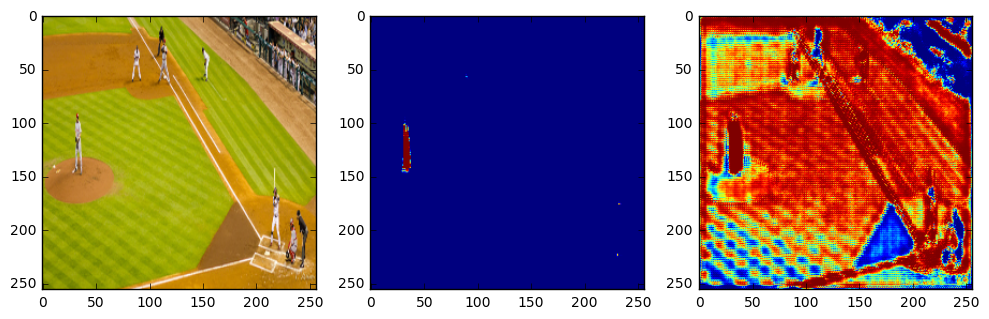

In [43]:
'''
2017-05-09-10-03-04_fil64_adam_lr0.0001_glorot_uniform_shape256x256_data_aug_weights.epoch0080-val_loss-0.78-val_dice_coef0.78.hdf5
COCO_val2014_000000000589
COCO_val2014_000000000139
COCO_val2014_000000000257
COCO_val2014_000000000283
COCO_val2014_000000000328
COCO_val2014_000000000338
COCO_val2014_000000000357
'''

img = io.imread("./data/val2014/COCO_val2014_000000000357.jpg")
img = cv2.resize(img, (256, 256))
img = np.expand_dims(img, axis=0)


with K.tf.device('/cpu:0'):
        output = model.predict(img)
        print(img.shape, output.shape)
        img2 = np.dstack((img[0], output[0]))
        print(img2.shape)
        img2 = np.expand_dims(img2, axis=0)
        print(img2.shape)
        output2 = model2.predict(img2)




mat1 = [
    [
        lambda x: plt.imshow(img[0]),
        lambda x: plt.imshow(output[0]),
        lambda x: plt.imshow(output2[0]),
    ]
]

mtx_plot(mat1, ratio=(4,4))